# **Flower Classification Competition (30%)**
For this competition, we will use the Flower Recognition. This dataset contains 4317 images of flowers. The data collection is based on the data from flickr, google images, yandex images. The aim is to recognize flower species from a photo.  

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Note that for this dataset the photos are not all at a fixed size, they have different proportions.

We provide baseline code that includes the following features:

*   Loading and Analysing the Flowers dataset using torchvision.
*   Providing some augmentations (on loading)
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following improvements could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Additional/better data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other variants.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 100) = acc_mark + efficiency mark + report mark  
###Acc_mark 20:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 20 marks. There will be a sliding scale applied in between.

###Efficiency mark 20:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 20 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 60:  
Your report should comprise:  
1. An introduction showing your understanding of the task and of the baseline model: [20 marks]

2. A description of how you have modified aspects of the system to improve performance. [20 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [10 marks]

4. Limitations/Conclusions: [10 marks]

In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Flowers Classification Competition
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

In [2]:
# Importing libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [3]:
# Performing Image Transformations.

train_transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
data_directory = '/content/drive/MyDrive/Datasets/flower/flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Mounted at /content/drive


Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /content/drive/MyDrive/Datasets/flower/flowers
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
# Checking the flower class types.
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [6]:
# Train and Test data split.
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [7]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
device = get_default_device()
device

device(type='cuda')

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10)

In [10]:
print(len(train_data))
print(len(test_data))

3453
864


In [11]:
# Preview of the datasets.
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [1 1 3 2 4 2 1 3 1 1]
Class: dandelion dandelion sunflower rose tulip rose dandelion sunflower dandelion dandelion


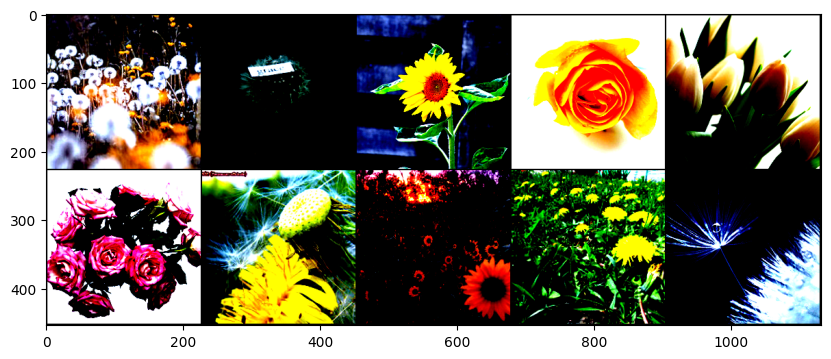

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
# Inverse Normalization.
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

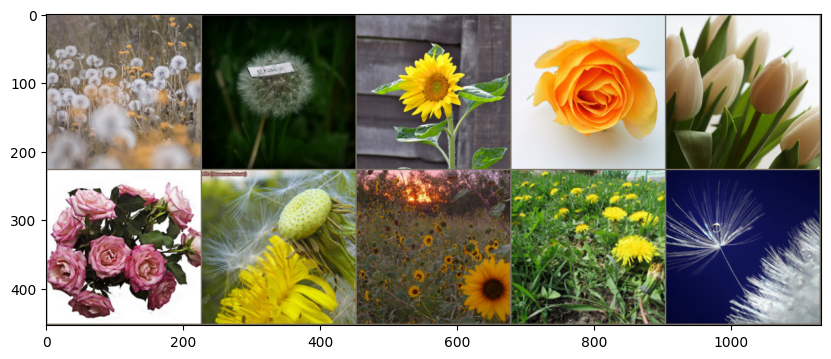

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [15]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.conv3=nn.Conv2d(16,32,3,1)

        self.fc1=nn.Linear(32*26*26,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)

        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)

        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)

        X=X.view(-1,32*26*26)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)

        return F.log_softmax(X, dim=1)

In [16]:
num_classes = 5
CNNmodel=to_device(ConvolutionalNetwork(num_classes),device)
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [17]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=5, bias=True)
)

In [18]:
# Counting of number of parameters in the model.
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

     162
       6
     864
      16
    4608
      32
 2595840
     120
   10080
      84
    1680
      20
     100
       5
________
 2613617


In [20]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=5

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        # print(X_train.device,y_train.device)
        y_pred=CNNmodel(X_train)
        # print(y_pred.device)
        loss=criterion(y_pred,y_train)

        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Note that this line only gives training accuracy
        if b%10==0:
            print(f"epoch: {i} loss: {loss.item()} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach()
    train_losses.append(loss.cpu().numpy())
    train_correct.append(trn_corr.cpu().numpy())


    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=CNNmodel(X_test)
            loss=criterion(y_val,y_test)

            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

        loss=loss.detach().cpu().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr.cpu().numpy())
    print(f'epoch: {i}, test accuracy: {tst_corr*100/len(test_data):7.3f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 0 loss: 1.6345134973526 batch: 10 accuracy:  24.000%
epoch: 0 loss: 1.6927461624145508 batch: 20 accuracy:  20.000%
epoch: 0 loss: 1.5669853687286377 batch: 30 accuracy:  21.000%
epoch: 0 loss: 1.547194242477417 batch: 40 accuracy:  22.750%
epoch: 0 loss: 1.6445837020874023 batch: 50 accuracy:  24.000%
epoch: 0 loss: 1.4934911727905273 batch: 60 accuracy:  27.667%
epoch: 0 loss: 1.425184965133667 batch: 70 accuracy:  27.857%
epoch: 0 loss: 1.3121649026870728 batch: 80 accuracy:  29.125%
epoch: 0 loss: 0.9110689163208008 batch: 90 accuracy:  31.333%
epoch: 0 loss: 1.739781141281128 batch: 100 accuracy:  33.500%
epoch: 0 loss: 1.1810389757156372 batch: 110 accuracy:  34.364%
epoch: 0 loss: 1.246084451675415 batch: 120 accuracy:  35.167%
epoch: 0 loss: 1.2326048612594604 batch: 130 accuracy:  35.385%
epoch: 0 loss: 1.3405946493148804 batch: 140 accuracy:  36.071%
epoch: 0 loss: 1.3151642084121704 batch: 150 accuracy:  36.733%
epoch: 0 loss: 1.2623248100280762 batch: 160 accuracy:  

[array(1.2847998, dtype=float32),
 array(0.47551468, dtype=float32),
 array(1.20463, dtype=float32),
 array(1.6242691, dtype=float32),
 array(0.03995948, dtype=float32)]

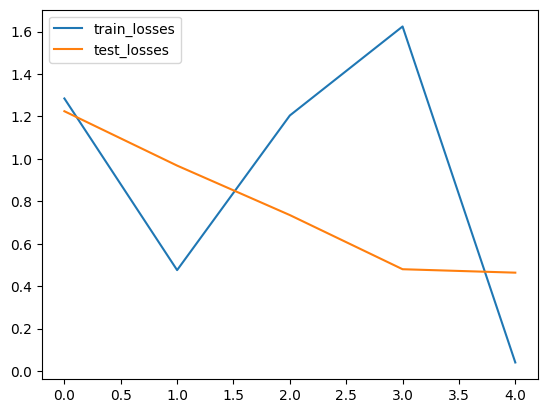

In [21]:
# Plotting loss over time.
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
train_losses

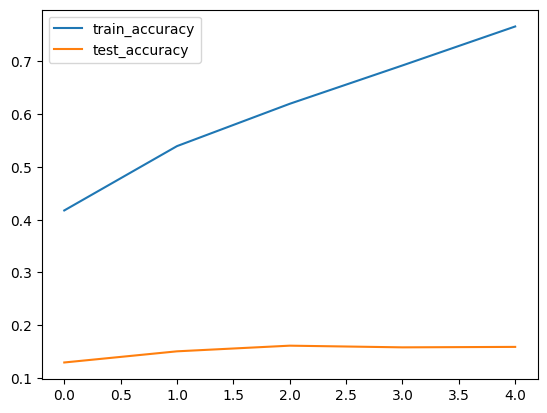

In [25]:
plt.plot(np.array(train_correct)/len(train_data),label="train_accuracy")
plt.plot(np.array(test_correct)/len(train_data),label="test_accuracy")
plt.legend()

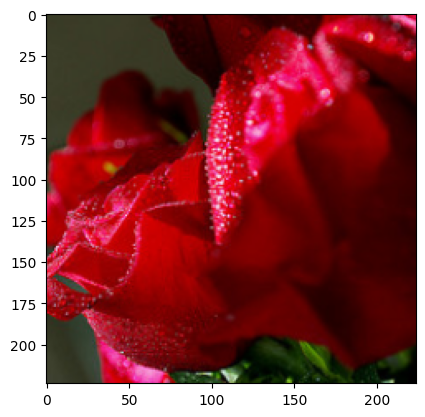

In [26]:
x=100
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [27]:
test_data[x][0].shape
test_data[x][0].device

device(type='cpu')

In [28]:
# Prediction for one of the samples.
CNNmodel.eval()
with torch.no_grad():
    new_pred=CNNmodel(to_device(test_data[x][0].view(1,3,224,224),device)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 2 rose


##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [29]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=37d8a12819da7730f0e52fbbf039e8e2da6a910de844052d4922aa043306e14a
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=ad6cf799994de3571876b94aab3198bb4c35fda00be5ddd7af2b47d97271dc6d
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [30]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 5
model = ConvolutionalNetwork(num_classes)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

FLOPs: 0.03332 GFLOPs
